##Part A: Data Preprocessing (Microclimate Data)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [26]:
micro_df = pd.read_csv('/content/drive/MyDrive/microclimate-sensors-data.csv')
print("Missing values per feature:\n", micro_df.isnull().sum())

Missing values per feature:
 Device_id                   0
Time                        0
SensorLocation           6143
LatLong                 11483
MinimumWindDirection    38525
AverageWindDirection      500
MaximumWindDirection    38683
MinimumWindSpeed        38683
AverageWindSpeed          500
GustWindSpeed           38683
AirTemperature            500
RelativeHumidity          500
AtmosphericPressure       500
PM25                    18110
PM10                    18110
Noise                   18110
dtype: int64


In [27]:
impute_values = {}

for column in micro_df.columns:
    if micro_df[column].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(micro_df[column]):
            median_val = micro_df[column].median()
            impute_values[column] = median_val
            micro_df[column].fillna(median_val, inplace=True)
        else:
            mode_val = micro_df[column].mode()[0]
            impute_values[column] = mode_val
            micro_df[column].fillna(mode_val, inplace=True)

print("\nReplacement values used:\n", impute_values)



Replacement values used:
 {'SensorLocation': '1 Treasury Place', 'LatLong': '-37.8185931, 144.9716404', 'MinimumWindDirection': 0.0, 'AverageWindDirection': 159.0, 'MaximumWindDirection': 353.0, 'MinimumWindSpeed': 0.0, 'AverageWindSpeed': 0.8, 'GustWindSpeed': 2.8, 'AirTemperature': 16.0, 'RelativeHumidity': 68.0, 'AtmosphericPressure': 1014.7, 'PM25': 3.0, 'PM10': 5.0, 'Noise': 68.3}


In [28]:
# Step 3: Split LatLong column into Latitude and Longitude
micro_df[['Latitude', 'Longitude']] = micro_df['LatLong'].str.split(',', expand=True).astype(float)
micro_df.drop('LatLong', axis=1, inplace=True)

In [29]:
# Step 4: Apply Min-Max scaling on continuous features
scaler = MinMaxScaler()
continuous_features = micro_df.select_dtypes(include=[np.number]).columns
scaled_data = pd.DataFrame(scaler.fit_transform(micro_df[continuous_features]), columns=continuous_features)


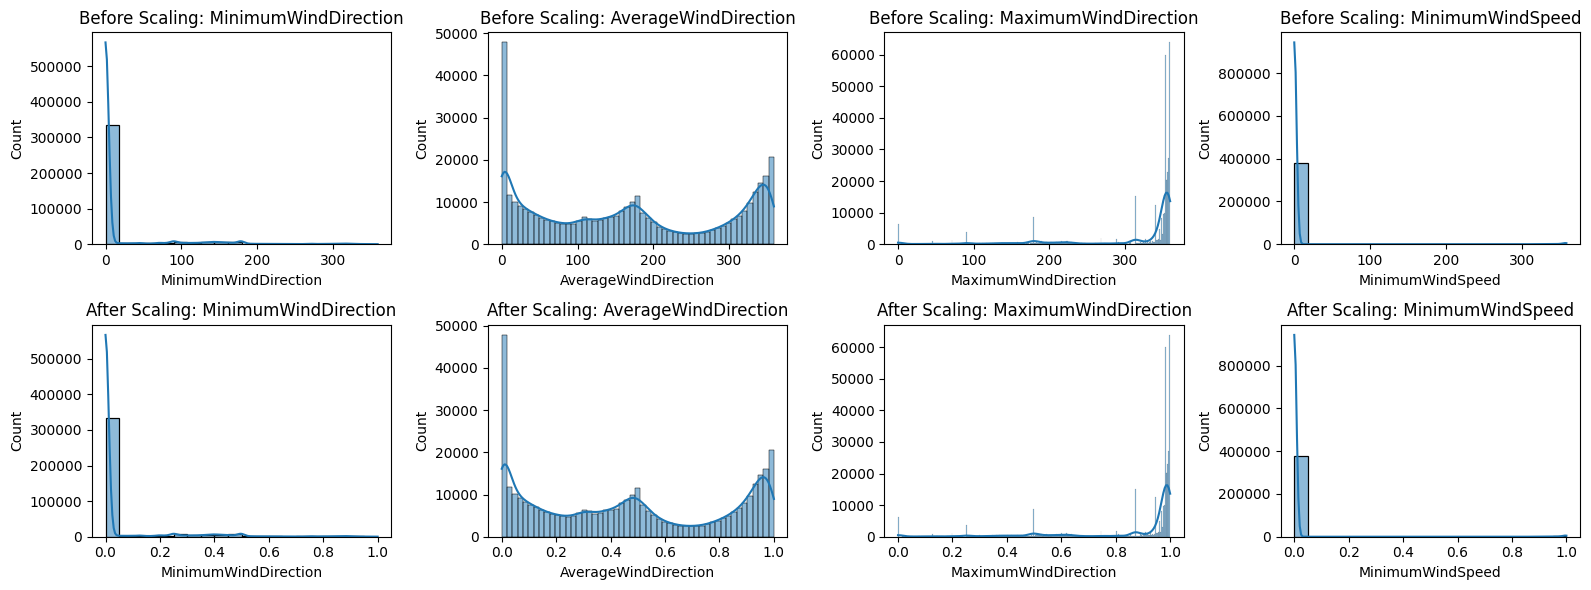

In [30]:
# Step 5: Plot distributions before and after scaling
plt.figure(figsize=(16, 6))
for i, col in enumerate(continuous_features[:4]):
    plt.subplot(2, 4, i+1)
    sns.histplot(micro_df[col], kde=True).set_title(f"Before Scaling: {col}")
    plt.subplot(2, 4, i+5)
    sns.histplot(scaled_data[col], kde=True).set_title(f"After Scaling: {col}")
plt.tight_layout()
plt.show()

##Part B: Clustering and PCA




In [31]:
# PART B: Clustering and PCA

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Step 6: Load Obesity dataset
obesity_df = pd.read_csv("/content/drive/MyDrive/Obesity.csv")
X_obesity = obesity_df.drop("NObeyesdad", axis=1)

In [33]:
# Step 6: Load the Obesity dataset
obesity_df = pd.read_csv('/content/drive/MyDrive/Obesity.csv')
X_obesity = obesity_df.drop("NObeyesdad", axis=1)

# Step 7: Encode categorical features
X_encoded = pd.get_dummies(X_obesity)

# Step 8: Silhouette Coefficient to determine best k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_encoded)
    sil = silhouette_score(X_encoded, labels)
    sil_scores.append(sil)

optimal_k = K[sil_scores.index(max(sil_scores))]
print("Optimal k based on silhouette score:", optimal_k)


Optimal k based on silhouette score: 2


In [34]:
# Step 9: Compare KMeans and KMeans++ using optimal k
kmeans_random = KMeans(n_clusters=optimal_k, init='random', random_state=42).fit(X_encoded)
kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42).fit(X_encoded)

print("Silhouette Score (KMeans - random):", silhouette_score(X_encoded, kmeans_random.labels_))
print("Silhouette Score (KMeans++):", silhouette_score(X_encoded, kmeans_plus.labels_))


Silhouette Score (KMeans - random): 0.5680587012452806
Silhouette Score (KMeans++): 0.5680587012452806


In [35]:
# Step 10: Gene expression PCA
gene_data = pd.read_csv('/content/drive/MyDrive/data.csv')
gene_labels = pd.read_csv('/content/drive/MyDrive/labels.csv')

# Remove sample ID if present
if not np.issubdtype(gene_data.dtypes[0], np.number):
    gene_data = gene_data.drop(columns=gene_data.columns[0])

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(gene_data)
print("Explained variance by 3 components:", pca.explained_variance_ratio_)


Explained variance by 3 components: [0.1583855  0.1050396  0.09472221]


In [36]:
# Step 11: KMeans on original and PCA features
n_clusters = 3  # arbitrarily choosing 3; or could silhouette-optimize again

kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42).fit(gene_data)
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42).fit(X_pca)

score_orig = silhouette_score(gene_data, kmeans_orig.labels_)
score_pca = silhouette_score(X_pca, kmeans_pca.labels_)

print("Silhouette Score (Original):", score_orig)
print("Silhouette Score (PCA):", score_pca)


Silhouette Score (Original): 0.16734701253476822
Silhouette Score (PCA): 0.47858196895111343
